In [ ]:
# If running on SWAN
import sys
import os
on_swan = False
if on_swan:
    home = os.path.expanduser("~")
    sys.path.insert(0, os.path.join(home, '.local/lib/python3.5/site-packages'))

# Sklearn
1. A very popular python ML library
2. Has numerous utility features to assist on all steps of the analysis pipeline
3. In production you want XGBoost/TensorFlow/theano, ML algorithms in Sklearn are a bit obsolete

### Load the data

In [1]:
import numpy as np
data = np.load('data.npz')
X, y = data["X"], data["y"]
print(X.shape, y.shape)

(4505, 2) (4505,)


### Create train/test split

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.5, random_state=1337)

### Plot the full dataset

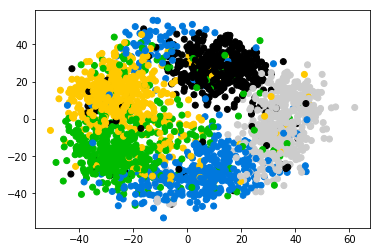

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='nipy_spectral');

### Display decision boundaries

In [4]:
from sklearn.metrics import accuracy_score
def plot_decision_surface(clf, X, y,
                          plot_step = 0.2,
                          cmap='nipy_spectral',
                          figsize=(12,8)
                         ):
    """
    For a sklearn-compartiable classifier plots the decision surface along with some
    points.
    Args:
       clf - a sklearn-compartiable classifier
       X - features array, shape=(n_objects, n_features)
       y - labels array, shape=(n_objcts)
       plot_strp - decision surface grid step
       cmap - color map
       figsize - figure size"""
    fig, ax = plt.subplots(figsize=figsize)
    n_classes = len(clf.classes_)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).ravel()
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap,alpha=0.5)    
    y_pred = clf.predict(X).ravel()

    ax.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='.',cmap=cmap,alpha=0.5,label='correct')
    ax.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #plt.axis("tight")
    ax.legend(loc='best')
    print("Accuracy = %f" % accuracy_score(y, y_pred))

### Training performance

In [5]:
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier

/home/kna/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
xgb_model = XGBClassifier().fit(X_train, Y_train)

In [7]:
catboost_model = CatBoostClassifier(loss_function="MultiClass").fit(X_train, Y_train)

Accuracy = 0.846359


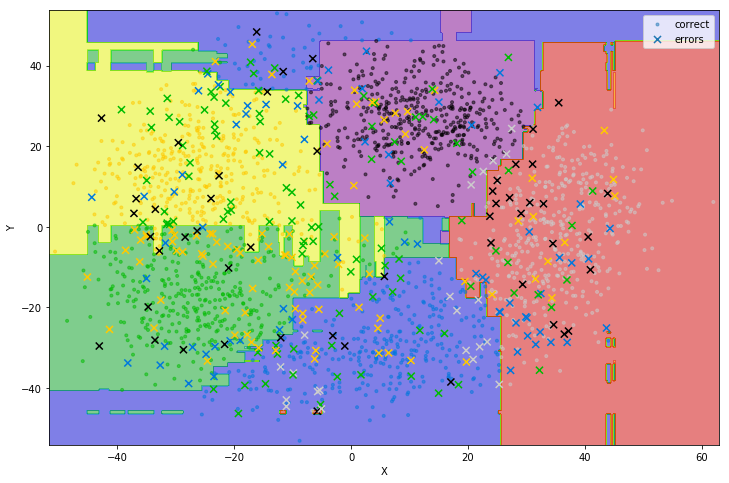

In [8]:
plot_decision_surface(xgb_model, X_train, Y_train);

In [9]:
xgb_model.feature_importances_

array([ 0.52879214,  0.47120786], dtype=float32)

### Validation performance

Accuracy = 0.796715


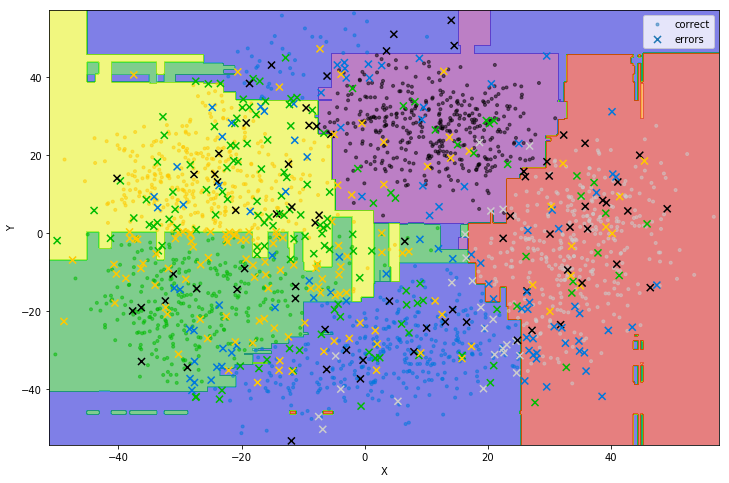

In [10]:
plot_decision_surface(xgb_model, X_test, Y_test);

Accuracy = 0.802042


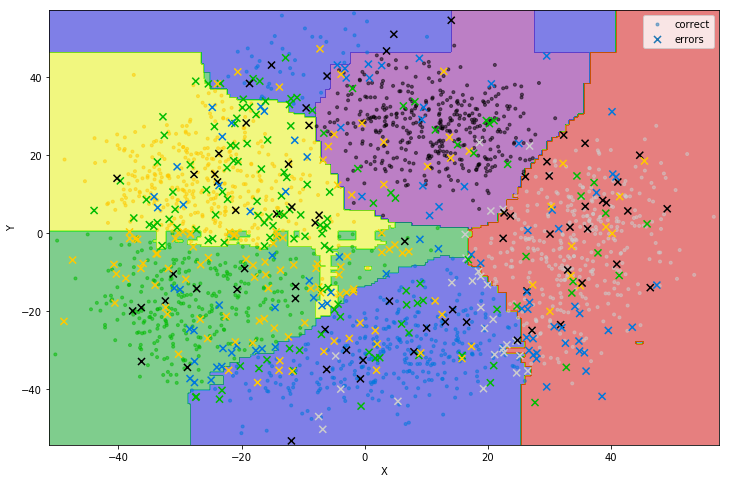

In [24]:
plot_decision_surface(catboost_model, X_test, Y_test);

In [25]:
# Do you think it's a fair quality comparison?

# Quality metrics
Too many of them, select according to your task. For binary classification the most common is ROC AUC.

In [12]:
Y_train_binary = (Y_train > 0)
Y_test_binary = (Y_test > 0)
binary_xgb = XGBClassifier().fit(X_train, Y_train_binary)

In [13]:
import sklearn.metrics

In [14]:
# Pay attention we use predict_proba(), not the simple predict()
# Also pay attention that predict_proba return shape in (n_obejcts, n_classes)
sklearn.metrics.roc_auc_score(Y_test_binary, binary_xgb.predict_proba(X_test)[:, 1])

0.92484226807342484

In [15]:
# Will fail
# sklearn.metrics.accuracy_score(Y_test, binary_xgb.predict_proba(X_test))

In [16]:
sklearn.metrics.accuracy_score(Y_test, binary_xgb.predict(X_test))

0.37283621837549935

# Cross-validation

In [17]:
from sklearn.model_selection import cross_val_score
import xgboost

In [18]:
cross_val_score(XGBClassifier(nthread=1), X, y, scoring="accuracy", n_jobs=-1, cv=3)

array([ 0.81648936,  0.78814124,  0.808     ])

In [19]:
cross_val_score(XGBClassifier(nthread=-1), X, y, scoring="accuracy", n_jobs=1, cv=3)

array([ 0.81648936,  0.78814124,  0.808     ])

In [20]:
# Fails due to some bug...
# cross_val_score(XGBClassifier(nthread=2), X, y, scoring="accuracy", n_jobs=2, cv=3)

## [Bonus] If you're deep into XGBoost...
Consider using its data format & cv

In [21]:
# Supports missing data, features names and types
dmatrix = xgboost.DMatrix(X, label=y.astype(np.int))

In [22]:
xgboost.cv({"max_depth": 5, "eta": 0.1}, dmatrix)
# Do you see a problem?

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,1.855247,0.017557,1.851807,0.008759
1,1.707606,0.016461,1.701146,0.008647
2,1.577691,0.015836,1.566994,0.008636
3,1.463575,0.015357,1.448710,0.008702
4,1.365278,0.015170,1.344973,0.008874
5,1.278778,0.014610,1.254198,0.009099
6,1.203692,0.015018,1.174540,0.009031
7,1.139788,0.015911,1.105653,0.009088
8,1.084766,0.015506,1.045861,0.009099
9,1.038611,0.016452,0.994141,0.009739


In [23]:
xgboost.cv({"max_depth": 5, "eta": 0.1, "ojective": 'multi:softmax', "num_class":6}, dmatrix, metrics={"merror"})

,test-merror-mean,test-merror-std,train-merror-mean,train-merror-std
0,0.204975,0.001256,0.168110,0.001547
1,0.203864,0.002371,0.167000,0.002857
2,0.202976,0.005055,0.165445,0.000566
3,0.201643,0.005283,0.163780,0.001132
4,0.202754,0.005170,0.162669,0.002199
5,0.201643,0.006801,0.163224,0.000720
6,0.202087,0.006801,0.163114,0.000416
7,0.199867,0.006816,0.162891,0.000272
8,0.199201,0.007478,0.160782,0.001662
9,0.198978,0.007927,0.160560,0.002176
